In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

import matplotlib as mpl
import scipy as sp
import scipy.stats as st
#from lmfit                import Model
from scipy.optimize       import curve_fit
from scipy.stats          import chi2
import pandas as pd

import sys
sys.path.append('/home/apizzuto/Nova/scripts/')
from Novae import Nova
from sensitivity_fit_functions import *

plt.style.use('/home/apizzuto/Nova/scripts/novae_plots.mplstyle')
#sns.palplot(sns.color_palette('colorblind'))
#palette = ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0', '#f0027f']
palette = sns.color_palette("pastel")
#sns.palplot(palette)

In [3]:
df = pd.read_csv('/home/apizzuto/Nova/Novae_details.csv')
df = df.sort_values('Start Time (gamma ray)')

In [4]:
def bg_trials_row(ind, spec='SPL'):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 3), dpi=200, sharey=True)
    #ts = np.logspace(-1., 7., 9)
    ts = np.logspace(2., 6., 3)
    for ii, t in enumerate(ts):
        bg = np.load('/data/user/apizzuto/Nova/analysis_trials/bg/kent/deltaT_{:.1e}_index_{}_spec_{}.npy'.format(t, ind, spec), allow_pickle=True).item()
        #xs = np.linspace(0., 20., 500); df=1
        #axs[ii].plot(xs, st.chi2.pdf(xs, df))
        axs[ii].hist(bg['TS'], bins=np.linspace(0., 20., 31), density=True)
        axs[ii].set_yscale('log')
        axs[ii].set_xlabel('TS')
        axs[ii].set_title('10$^{:.0f}$ s'.format(np.log10(t)))
    axs[0].set_ylabel('Prob. density')
    return fig
    
def sensitivity_row(ind, spec='SPL', all_flavor=True):
    fig, axs = plt.subplots(nrows=1, ncols=9, figsize=(19, 2.5), sharey=True)
    ts = np.logspace(-1., 7., 9)
    for ii, t in enumerate(ts):
        sensitivity_curve(ind, spectra=spec, deltaT=t, trim=-1, 
                          fontsize = 12, ax = axs[ii], legend=False, all_flavor=all_flavor)
        axs[ii].set_xlabel(r'$\langle n_{inj} \rangle$', fontsize = 14)
    axs[0].set_ylabel(r'Passing Fraction', fontsize = 14)

def sensitivity_vs_time(ind, spec='SPL', all_flavor=True):
    #ts = np.logspace(-1., 7., 17)
    ts = np.logspace(-1., 7., 17)[:-1]
    sens = []; good_ts = []
    for ii, t in enumerate(ts):
        try:
            sen = calc_sensitivity(ind, spectra=spec, deltaT=t, trim=-1, all_flavor=all_flavor)
            if sen is not None and sen['sens'] != 100. and sen['sens'] != 20.: #boundary cases mean minimizer failed
                sens.append(num_evs_to_flux(sen['sens'], ind, t, spectra=spec, all_flavor=all_flavor)*t)
                good_ts.append(t)
        except Exception, e:
            #print e
            continue
    return np.array(good_ts), np.array(sens)

ns = np.linspace(1, 20, 20)
levels = [2.5, 16., 84., 97.5]

def fits_from_file(f, levels = [2.5, 16., 84., 97.5], gamma=True):
    fits_dict = {}
    params = ['ns', 'gamma'] if gamma else ['ns']
    for param in params:
        fits = [f[param][results['ninj'] == n] for n in ns]
        levs = {'{:.2f}'.format(lev): np.percentile(fits, lev, axis=1) for lev in levels}
        meds = np.percentile(fits, 50, axis = 1)
        fits_dict[param] = {'median': meds, 'levels': levs}
    return fits_dict
 

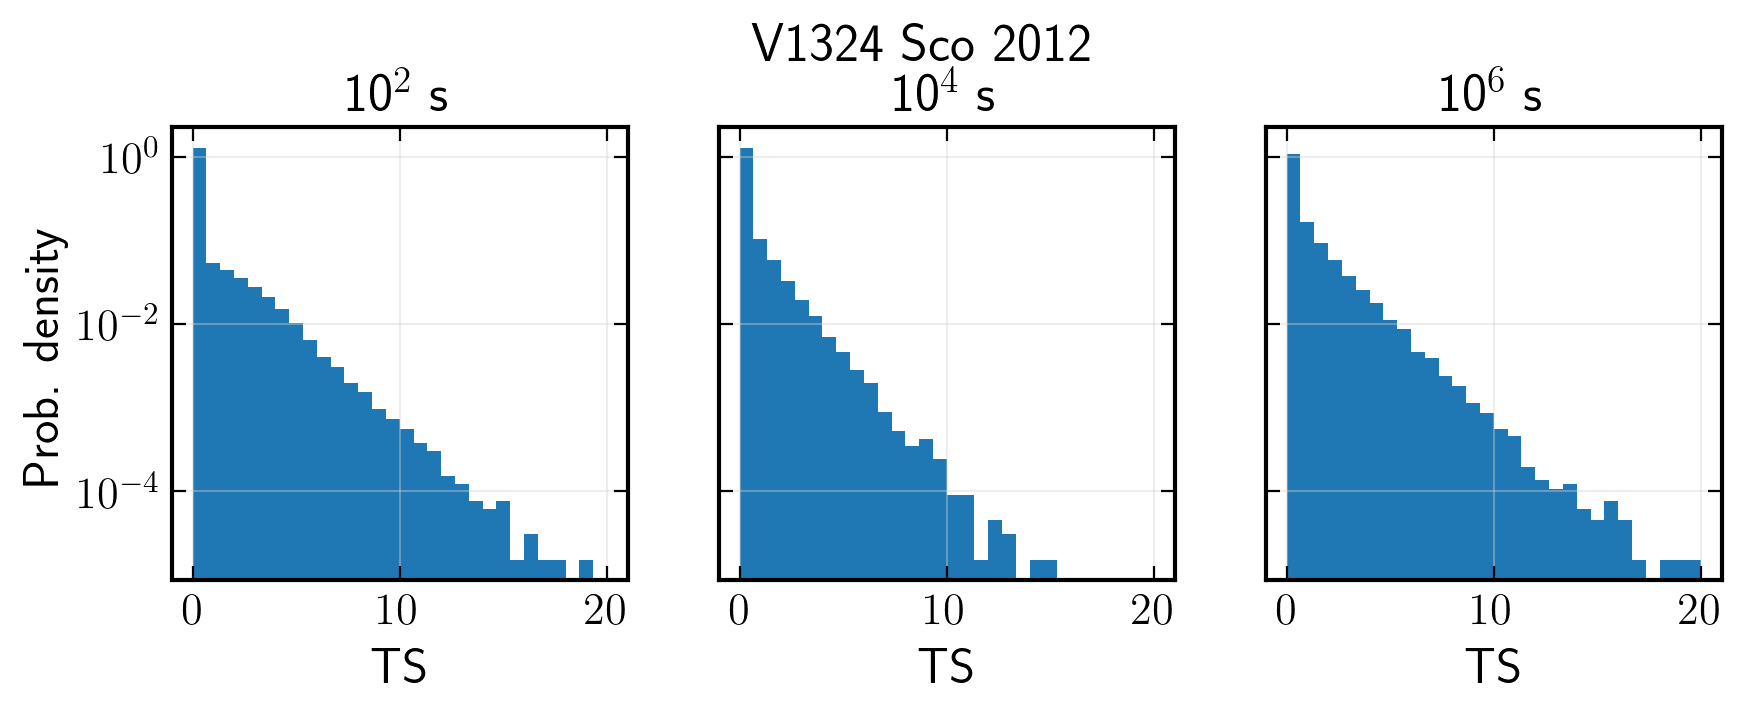

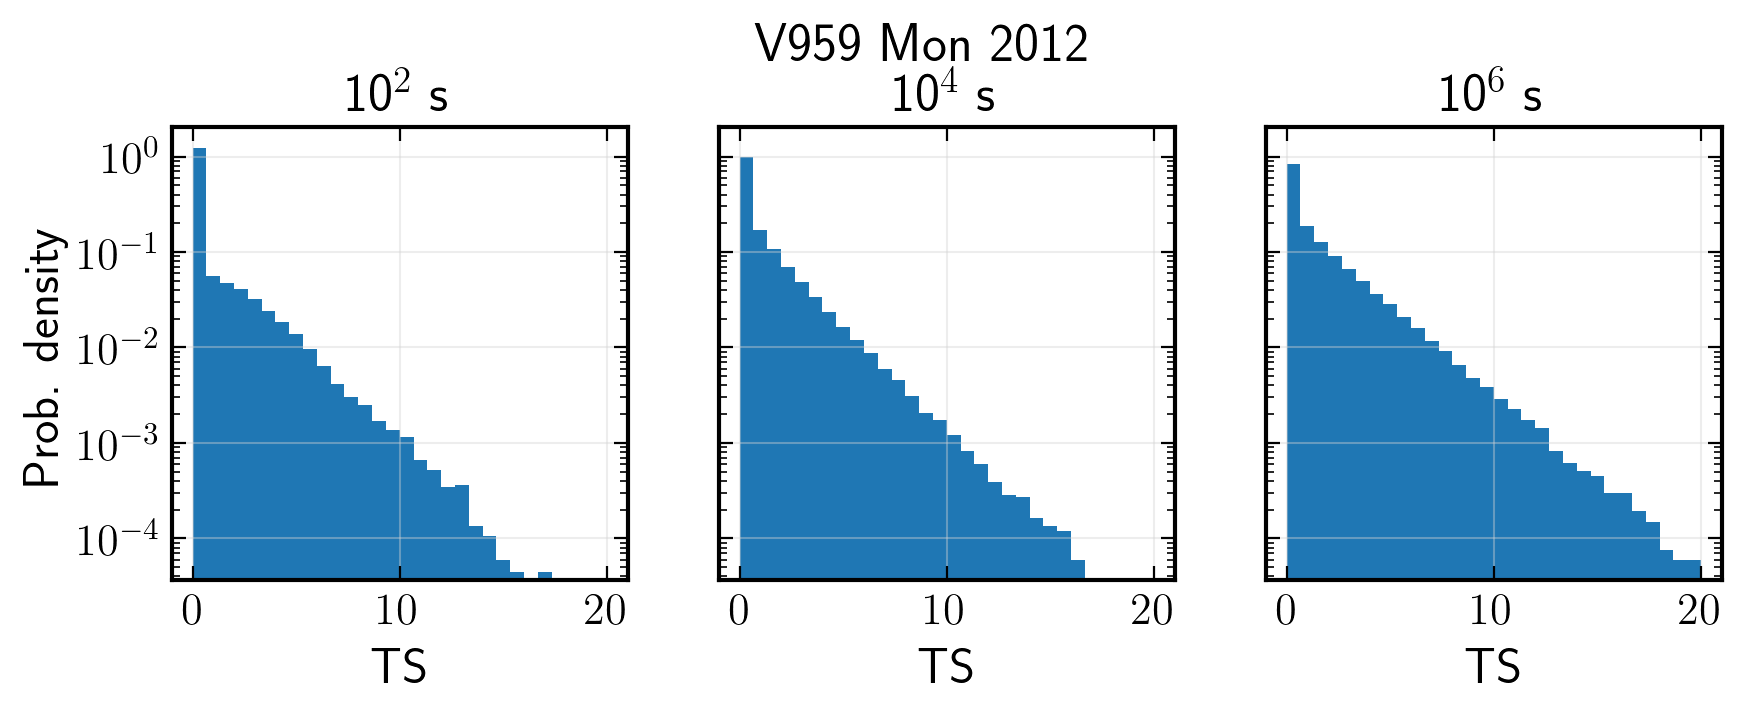

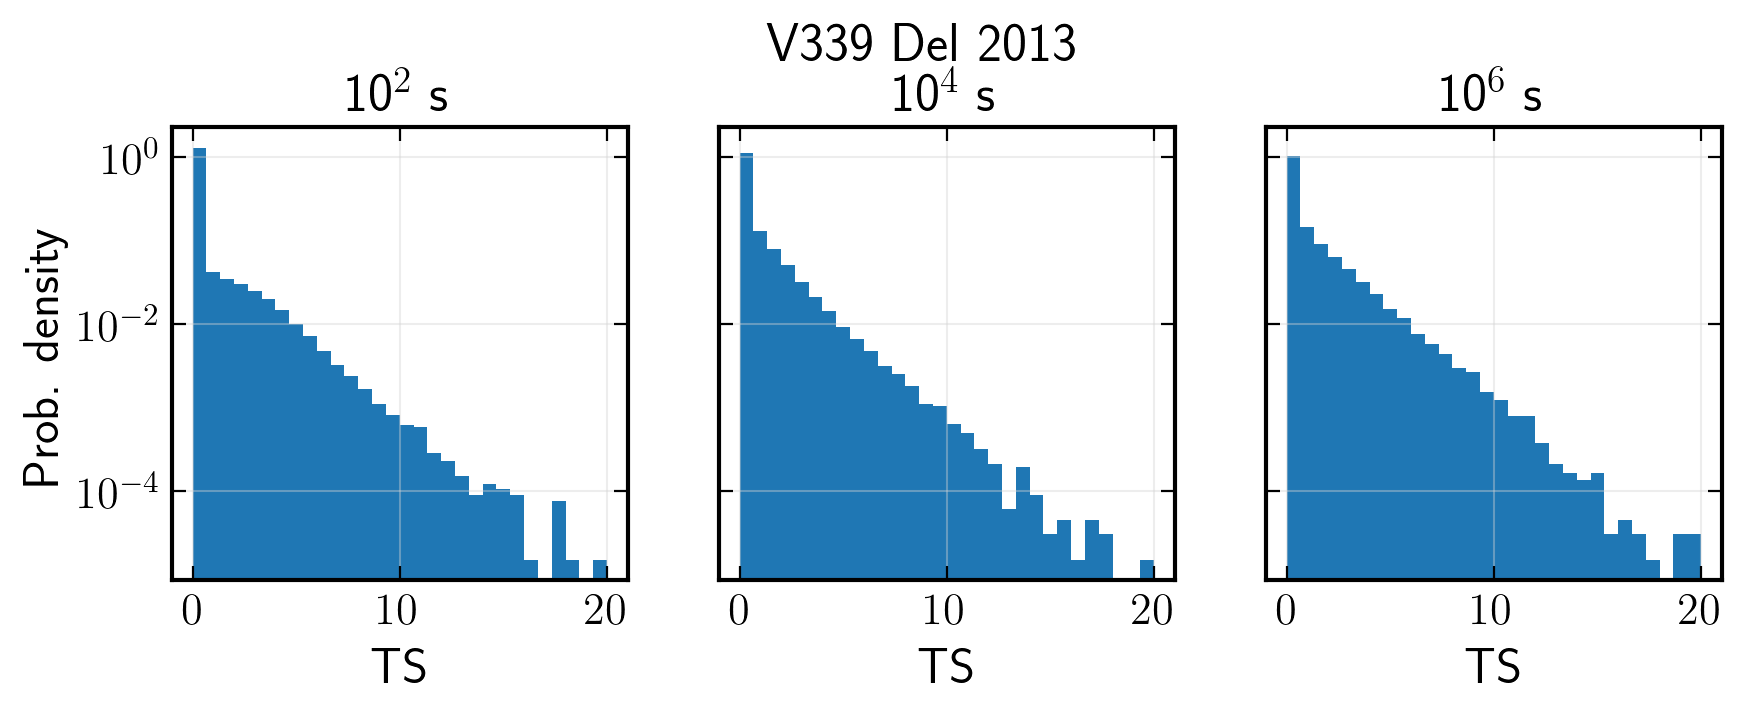

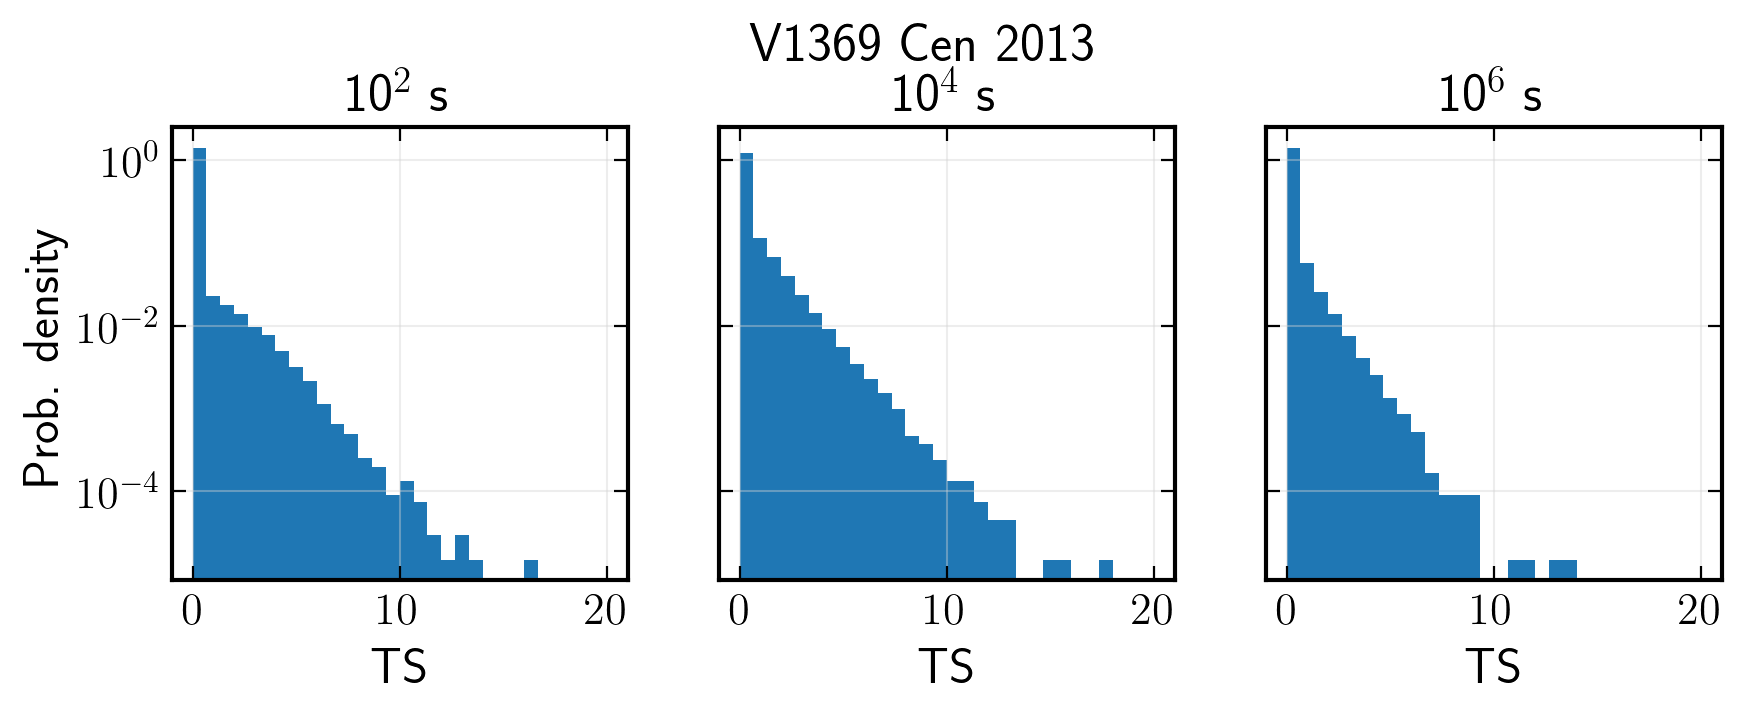

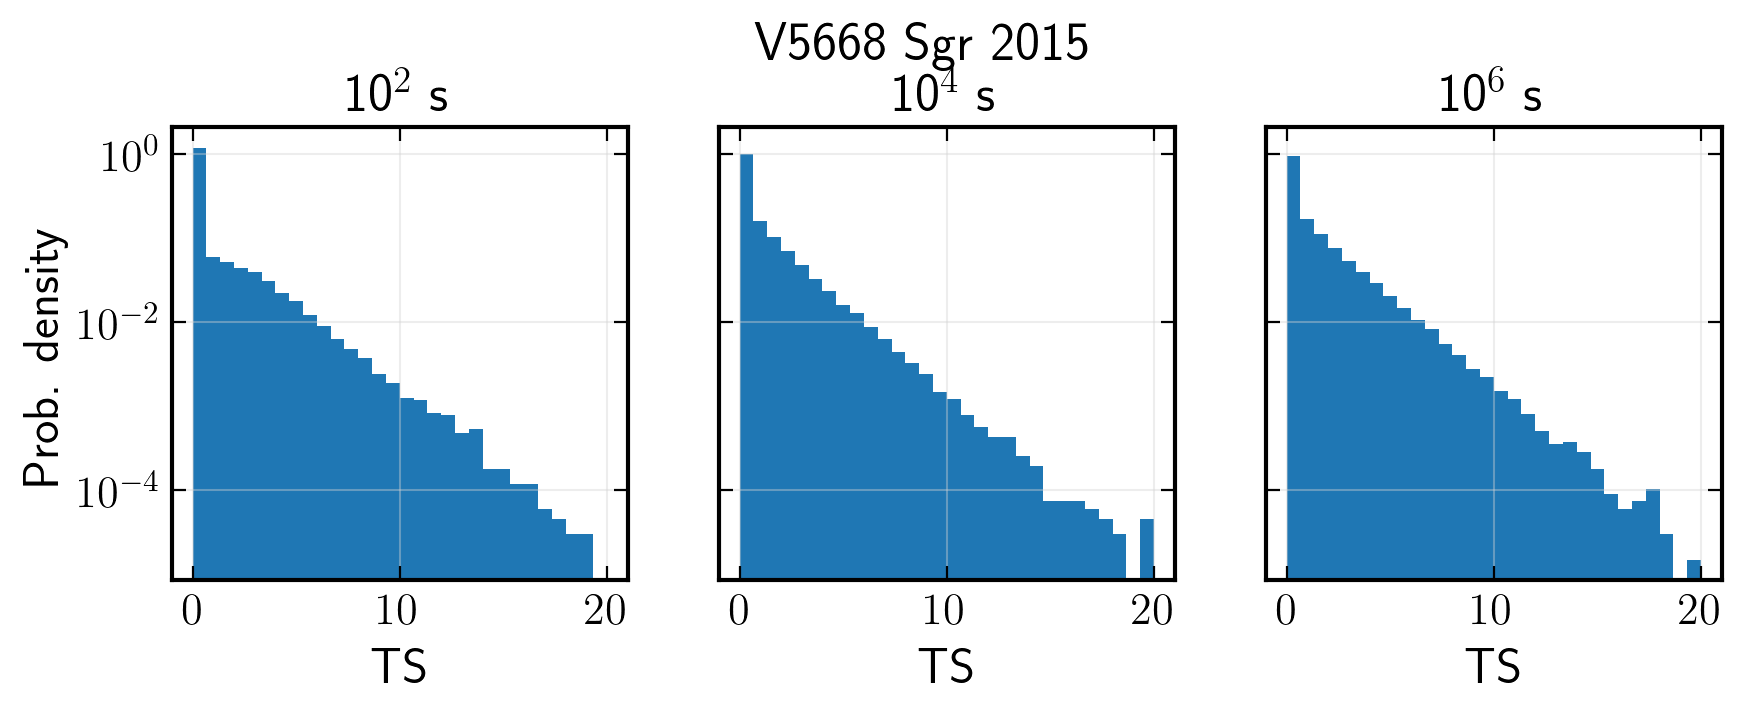

In [5]:
for ind, row in df.iterrows():
    if ind < 1:
        continue
    elif ind > 5:
        continue
    fig = bg_trials_row(ind)
    fig.suptitle(row['Name'], y=1.06)
    #sensitivity_row(ind, spec='SPL')
    plt.show()

/home/apizzuto/.venvs/nova/lib/python2.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


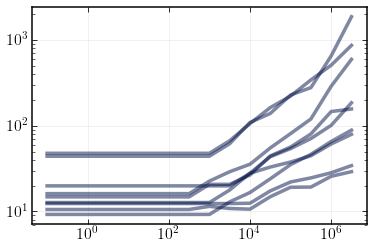

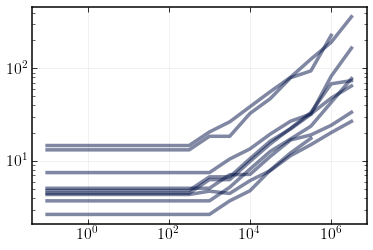

In [9]:
for ind in range(1, 10):
    sens = sensitivity_vs_time(ind, all_flavor=False)
    plt.plot(sens[0], sens[1], color=sns.xkcd_rgb['navy blue'], lw=3.5, alpha=0.5)

plt.loglog()
plt.show()

for ind in range(1, 10):
    sens = sensitivity_vs_time(ind, all_flavor=True)
    plt.plot(sens[0], sens[1], color=sns.xkcd_rgb['navy blue'], lw=3.5, alpha=0.5)

plt.loglog()
plt.show()

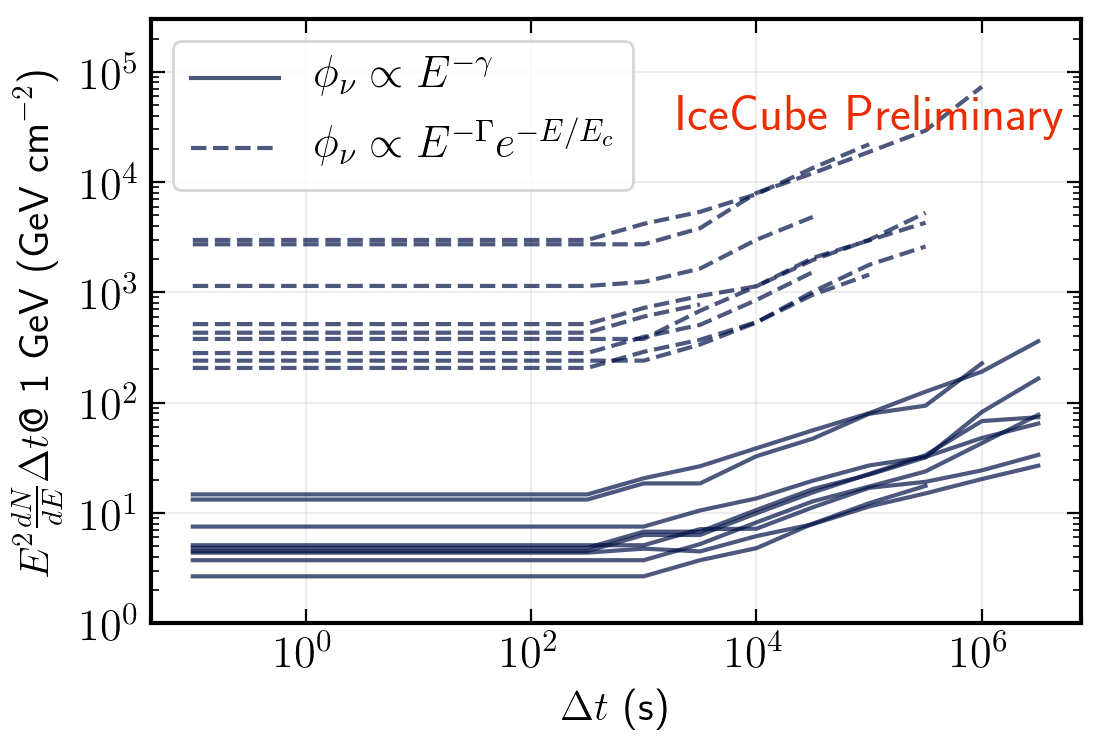

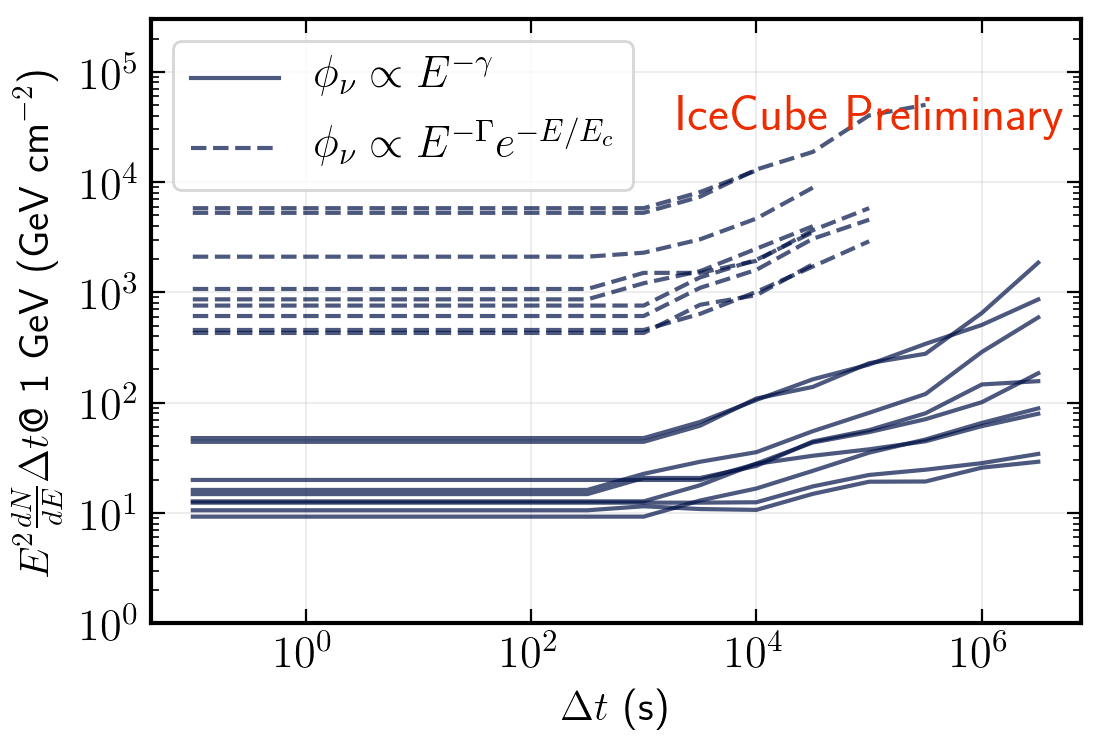

In [11]:
for all_flavor in [True, False]:
    fig = plt.figure(dpi=200)
    fig.set_facecolor('w')

    for ind in range(1, 10):
        spl_sens = sensitivity_vs_time(ind, spec = 'SPL', all_flavor=all_flavor)
        epl_sens = sensitivity_vs_time(ind, spec = 'EPL', all_flavor=all_flavor)
        if ind == 1:
            plt.plot(spl_sens[0], spl_sens[1] , color=sns.xkcd_rgb['navy blue'], lw=1.5, 
                     alpha=0.7, label = r'$\phi_{\nu} \propto E^{-\gamma}$')
            plt.plot(epl_sens[0], epl_sens[1] , color=sns.xkcd_rgb['navy blue'], lw=1.5, 
                     alpha=0.7, ls='--', label = r'$\phi_{\nu} \propto E^{-\Gamma}e^{-E/E_c}$')
        else:    
            plt.plot(spl_sens[0], spl_sens[1] , color=sns.xkcd_rgb['navy blue'], lw=1.5, alpha=0.7)
            plt.plot(epl_sens[0], epl_sens[1] , color=sns.xkcd_rgb['navy blue'], 
                     lw=1.5, alpha=0.7, ls='--')

    plt.legend(loc=2)
    plt.xlabel(r'$\Delta t$ (s)', fontsize = 15)
    plt.ylabel(r'$E^2 \frac{dN}{dE}\Delta t$@ 1 GeV (GeV cm$^{-2}$)', fontsize = 15)    
    plt.ylim(1e0, 3e5)

    plt.loglog()
    plt.text(2e3, 3e4, 'IceCube Preliminary', 
             color=sns.xkcd_rgb['tomato red'], fontsize=18)
    plt.savefig('/home/apizzuto/public_html/novae/time_integrated_sensitivity_all_flavor_{}_preliminary.png'.format(all_flavor), 
                dpi=150, bbox_inches='tight')
    plt.show()

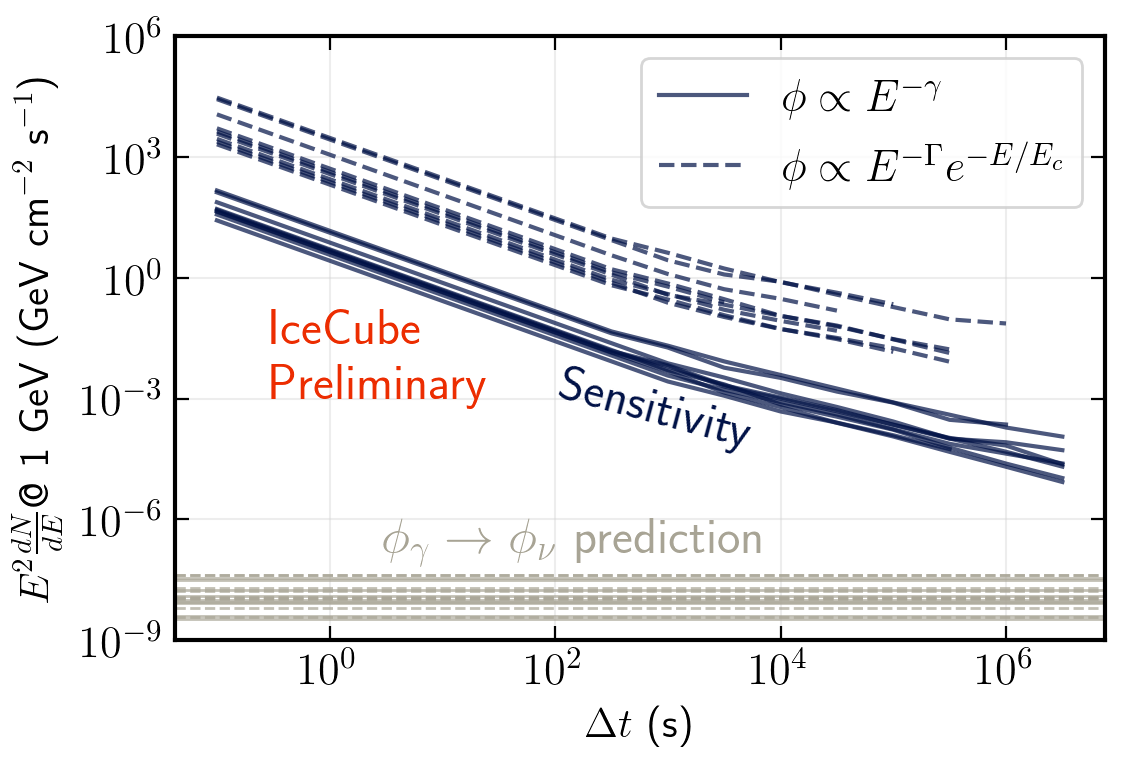

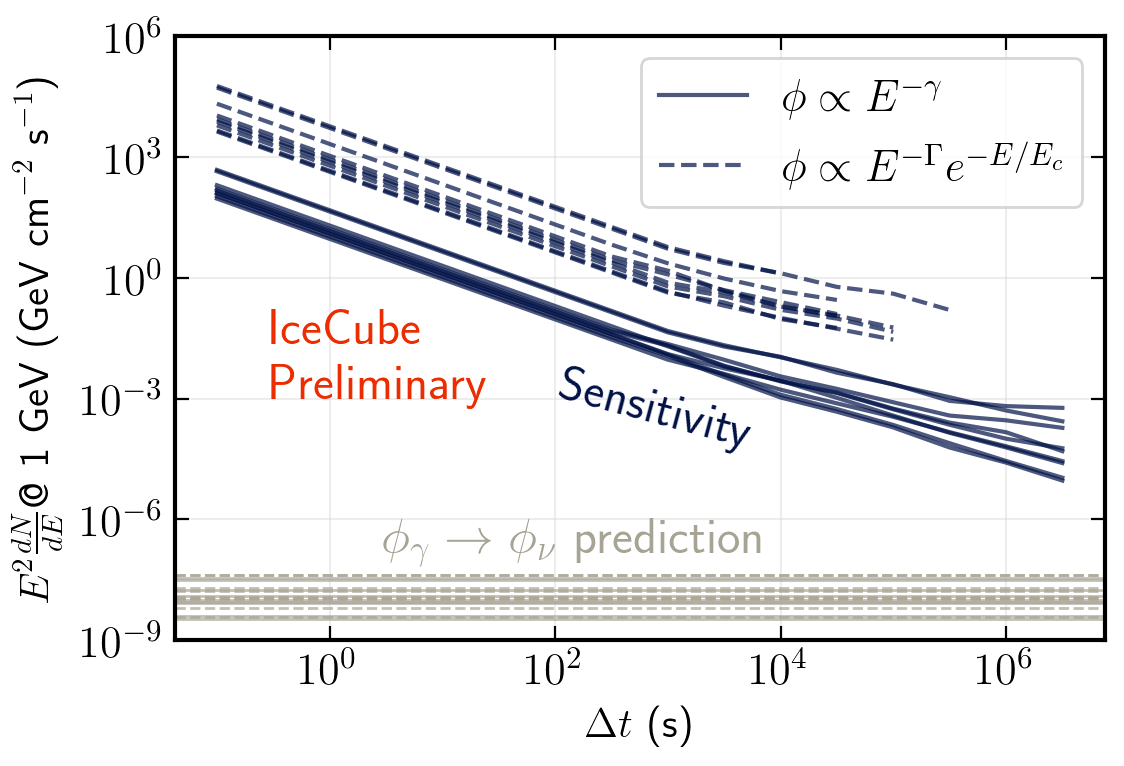

In [12]:
for all_flavor in [True, False]:
    fig = plt.figure(dpi=200)
    fig.set_facecolor('w')

    EPL_expectation, SPL_expectation = [], []
    for index, row in df.iterrows():
        en = 1.
        a = Nova(row['Name'], row['EPL gamma'], np.radians(row['RA (Deg)']), np.radians(row['Dec. (Deg)']), 
                    row['Start Time (gamma ray)'], row['Duration (gamma ray)'], flux_norm=row['EPL flux']*1e-7, cutoff = row['EPL cutoff '])
        EPL_expectation.append(a.neutrino_spectrum(en)*en**2)
        a = Nova(row['Name'], row['SPL gamma'], np.radians(row['RA (Deg)']), np.radians(row['Dec. (Deg)']), 
                    row['Start Time (gamma ray)'], row['Duration (gamma ray)'], flux_norm=row['SPL flux']*1e-7, cutoff = None)
        SPL_expectation.append(a.neutrino_spectrum(en)*en**2)

    for ind in range(1, 10):
        spl_sens = sensitivity_vs_time(ind, spec = 'SPL', all_flavor=all_flavor)
        epl_sens = sensitivity_vs_time(ind, spec = 'EPL', all_flavor=all_flavor)
        if ind == 1:
            plt.plot(spl_sens[0], spl_sens[1] / spl_sens[0], color=sns.xkcd_rgb['navy blue'], lw=1.5, 
                     alpha=0.7, label = r'$\phi \propto E^{-\gamma}$')
            plt.plot(epl_sens[0], epl_sens[1] / epl_sens[0], color=sns.xkcd_rgb['navy blue'], lw=1.5, 
                     alpha=0.7, ls='--', label = r'$\phi \propto E^{-\Gamma}e^{-E/E_c}$')
        else:    
            plt.plot(spl_sens[0], spl_sens[1] / spl_sens[0], color=sns.xkcd_rgb['navy blue'], lw=1.5, alpha=0.7)
            plt.plot(epl_sens[0], epl_sens[1] / epl_sens[0], color=sns.xkcd_rgb['navy blue'], 
                     lw=1.5, alpha=0.7, ls='--')

    for ii in range(1, 10):
        plt.axhline(SPL_expectation[ii], color = sns.xkcd_rgb['greyish'], lw = 1., alpha = 0.7)
        plt.axhline(EPL_expectation[ii], color = sns.xkcd_rgb['greyish'], lw = 1., alpha = 0.7, ls = '--')

    plt.text(3e0, 1e-7, r'$\phi_{\gamma}\rightarrow \phi_{\nu}$ prediction', 
             color = sns.xkcd_rgb['greyish'], fontsize = 18)
    plt.text(1e2, 1e-3, r'Sensitivity', color = sns.xkcd_rgb['navy blue'], 
             rotation = -15., fontsize = 18)
    plt.legend(loc=1)
    plt.xlabel(r'$\Delta t$ (s)', fontsize = 15)
    plt.ylabel(r'$E^2 \frac{dN}{dE}$@ 1 GeV (GeV cm$^{-2}$ s$^{-1}$)', fontsize = 15)    
    plt.ylim(1e-9, 1e6)

    plt.loglog()
    plt.text(3e-1, 1e-3, 'IceCube \n Preliminary', 
             color=sns.xkcd_rgb['tomato red'], fontsize=18)
    plt.savefig('/home/apizzuto/public_html/novae/flux_sensitivity_all_flavor_{}_preliminary.png'.format(all_flavor), 
                dpi=150, bbox_inches='tight')
    plt.show()

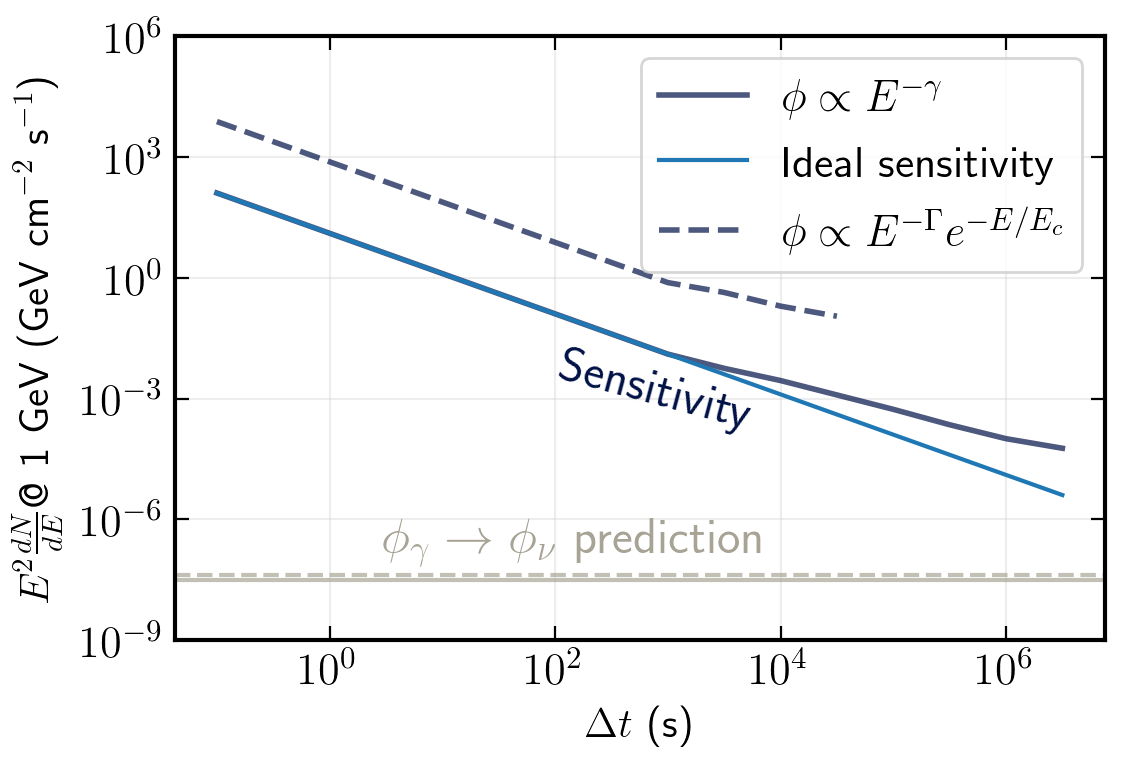

In [17]:
fig = plt.figure(dpi=200)
fig.set_facecolor('w')

EPL_expectation, SPL_expectation = [], []
for index, row in df.iterrows():
    en = 1.
    a = Nova(row['Name'], row['EPL gamma'], np.radians(row['RA (Deg)']), np.radians(row['Dec. (Deg)']), 
                row['Start Time (gamma ray)'], row['Duration (gamma ray)'], flux_norm=row['EPL flux']*1e-7, cutoff = row['EPL cutoff '])
    EPL_expectation.append(a.neutrino_spectrum(en)*en**2)
    a = Nova(row['Name'], row['SPL gamma'], np.radians(row['RA (Deg)']), np.radians(row['Dec. (Deg)']), 
                row['Start Time (gamma ray)'], row['Duration (gamma ray)'], flux_norm=row['SPL flux']*1e-7, cutoff = None)
    SPL_expectation.append(a.neutrino_spectrum(en)*en**2)

for ind in range(1, 2):
    spl_sens = sensitivity_vs_time(ind, spec = 'SPL')
    epl_sens = sensitivity_vs_time(ind, spec = 'EPL')
    if ind == 1:
        plt.plot(spl_sens[0], spl_sens[1] / spl_sens[0], color=sns.xkcd_rgb['navy blue'], lw=2, 
                 alpha=0.7, label = r'$\phi \propto E^{-\gamma}$')
        plt.plot(spl_sens[0], spl_sens[1][0]/spl_sens[0], label = 'Ideal sensitivity')
        plt.plot(epl_sens[0], epl_sens[1] / epl_sens[0], color=sns.xkcd_rgb['navy blue'], lw=2, 
                 alpha=0.7, ls='--', label = r'$\phi \propto E^{-\Gamma}e^{-E/E_c}$')
    else:    
        plt.plot(spl_sens[0], spl_sens[1] / spl_sens[0], color=sns.xkcd_rgb['navy blue'], lw=2, alpha=0.7)
        plt.plot(epl_sens[0], epl_sens[1] / epl_sens[0], color=sns.xkcd_rgb['navy blue'], 
                 lw=2, alpha=0.7, ls='--')

for ii in range(1, 2):
    plt.axhline(SPL_expectation[ii], color = sns.xkcd_rgb['greyish'], lw = 1.5, alpha = 0.7)
    plt.axhline(EPL_expectation[ii], color = sns.xkcd_rgb['greyish'], lw = 1.5, alpha = 0.7, ls = '--')
    
plt.text(3e0, 1e-7, r'$\phi_{\gamma}\rightarrow \phi_{\nu}$ prediction', 
         color = sns.xkcd_rgb['greyish'], fontsize = 18)
plt.text(1e2, 3e-3, r'Sensitivity', color = sns.xkcd_rgb['navy blue'], 
         rotation = -15., fontsize = 18)
plt.legend(loc=1)
plt.xlabel(r'$\Delta t$ (s)', fontsize = 15)
plt.ylabel(r'$E^2 \frac{dN}{dE}$@ 1 GeV (GeV cm$^{-2}$ s$^{-1}$)', fontsize = 15)    
plt.ylim(1e-9, 1e6)

plt.loglog()
plt.show()

# Differential Sensitivities

In [5]:
def differential_sensitivity(ind, delta_t=1e5, spec='SPL', all_flavor=True):
    e_bins = np.logspace(0., 3., 4)
    sens = []; good_ens = []
    for ii, en in enumerate(e_bins):
        try:
            sen = calc_sensitivity(ind, spectra=spec, deltaT=delta_t, trim=-1, 
                                   differential = True, lowE = en, all_flavor=all_flavor)
        except:
            continue
        if sen is not None and sen['sens'] != 20. and sen['sens'] != 100.:
            sens.append(num_evs_to_flux(sen['sens'], ind, delta_t, spectra=spec,
                                       differential=True, lowE=en, all_flavor=all_flavor))
            good_ens.append(en*np.sqrt(10.))
    return np.array(good_ens), np.array(sens)

erg_to_TeV = 0.624151
nu_model = np.loadtxt('../models/16ma_neutrino.txt').T
mu_flux = (nu_model[2] + nu_model[4]) / 2. * erg_to_TeV
e_flux = (nu_model[1] + nu_model[3]) / 2. * erg_to_TeV
model_ens = nu_model[0]

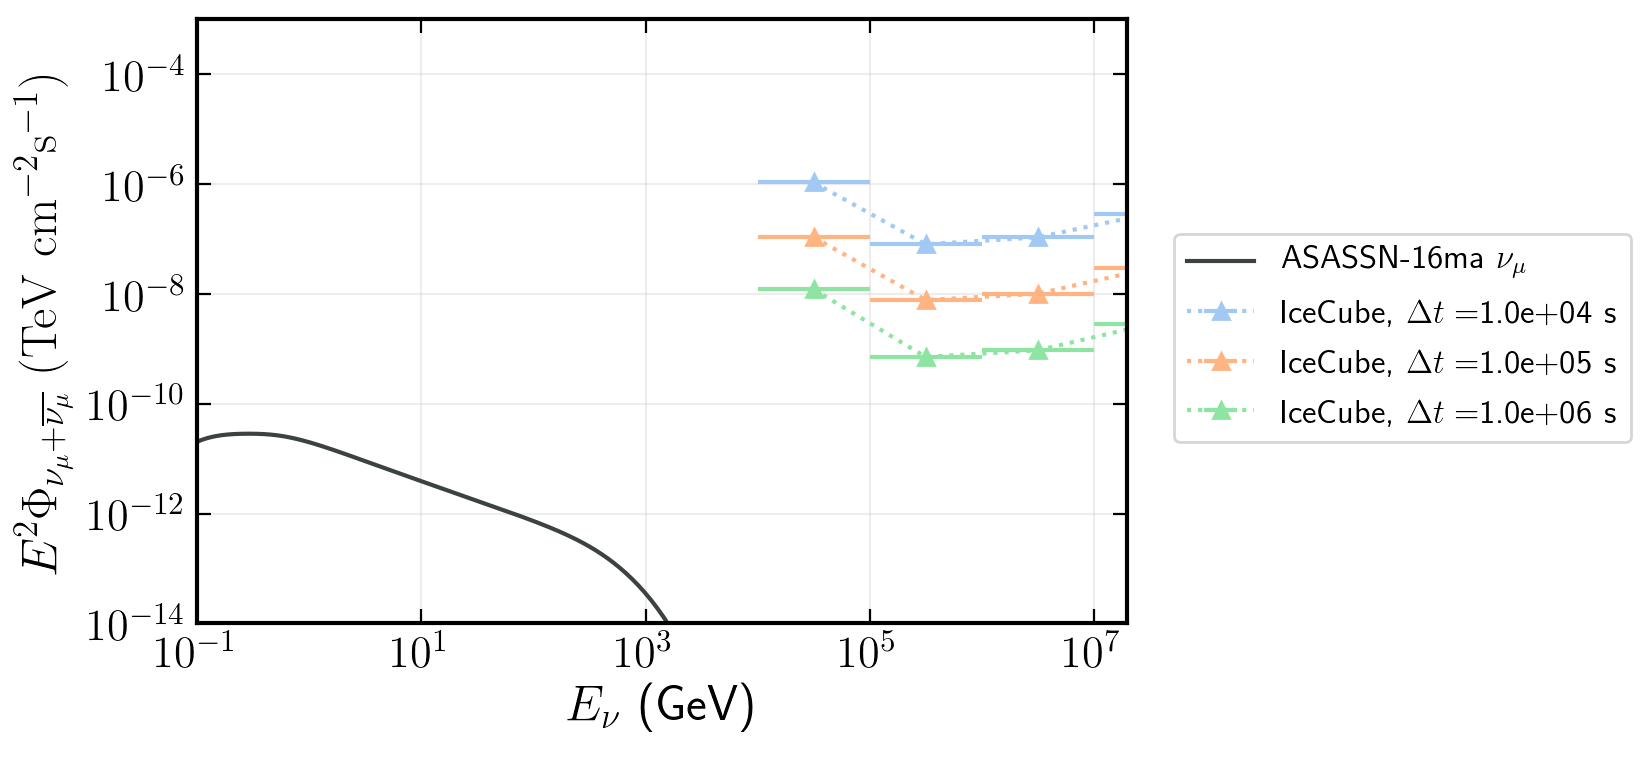

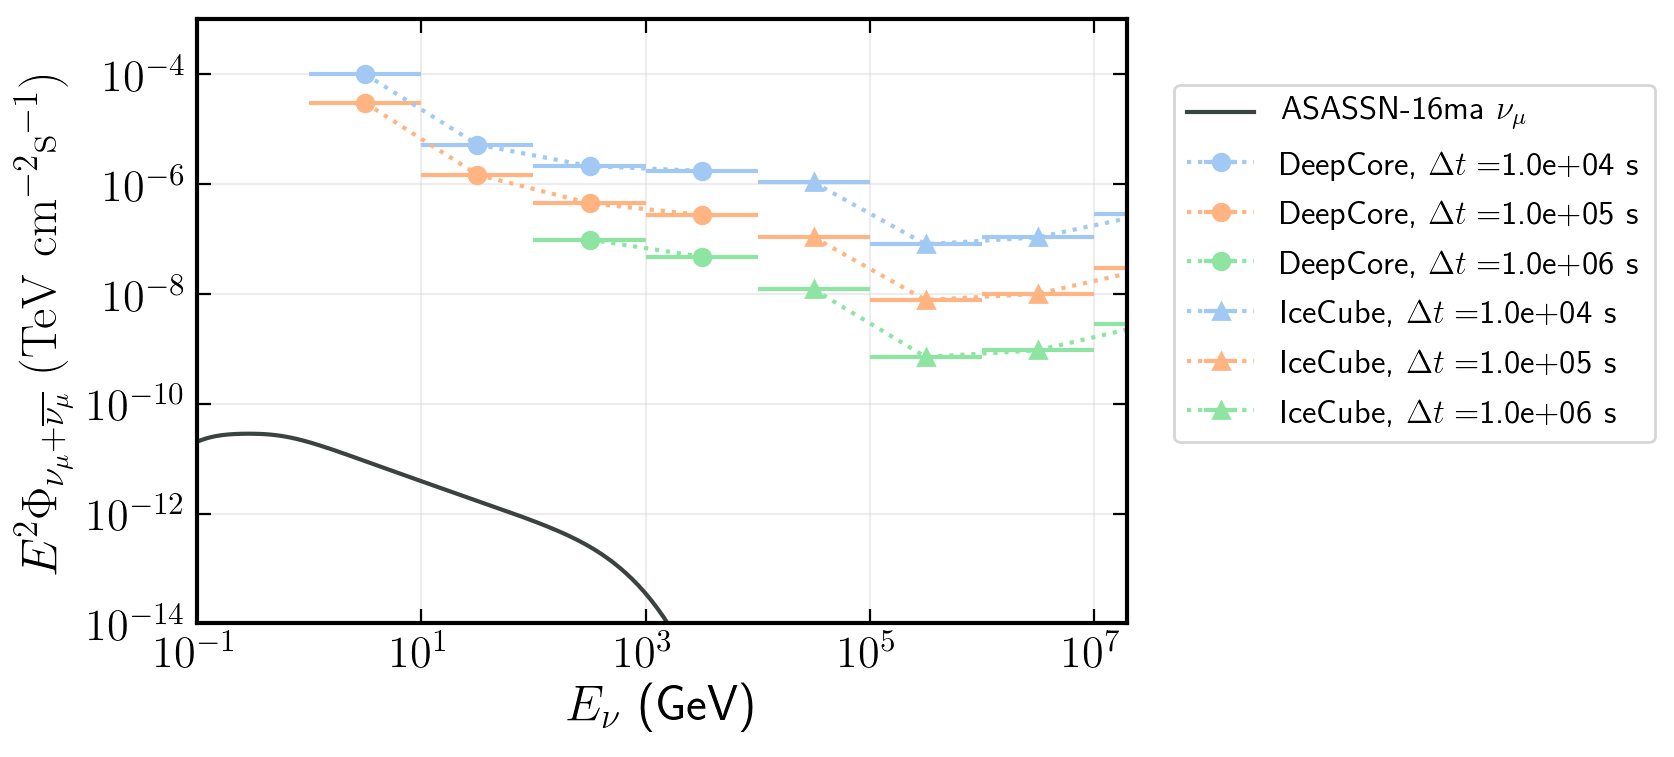

In [14]:
for all_flavor in [True, False]:
    fig = plt.figure(dpi=200)
    fig.set_facecolor('w')
    bin_width = np.sqrt(10.)

    for ii, delta_t in enumerate(np.logspace(4., 6., 3)):
        try:
            diff_e = differential_sensitivity(9, delta_t = delta_t, all_flavor=all_flavor) #ind 9 is ASASSN-16ma
            plt.errorbar(diff_e[0], diff_e[1]*1e-3,  #From GeV to TeV
                xerr=[diff_e[0]-diff_e[0]/bin_width, diff_e[0]*bin_width-diff_e[0]],
                marker='o', ls=':', label=r'DeepCore, $\Delta t = $' + '{:.1e} s'.format(delta_t),
                color = palette[ii])
        except:
            continue


    for ii, delta_t in enumerate(np.logspace(4., 6., 3)):
        ndays = delta_t / 86400.
        gfu = np.load('/data/user/apizzuto/fast_response_skylab/dump/differential_sensitivity_deltaT_{:.2e}_sinDec_-0.50.pkl'.format(ndays),
                   allow_pickle=True)
        ens = np.array(gfu['low_energies'])*np.sqrt(10.)
        sens = np.array(gfu['sensitivity']) * 1e3 #1e6 for E_0^2, 1e-3 for GeV to TeV
        plt.errorbar(ens, sens,  #From GeV to TeV
            xerr=[ens-ens/bin_width, ens*bin_width-ens],
            marker='^', ls=':', label=r'IceCube, $\Delta t = $' + '{:.1e} s'.format(delta_t),
                    color=palette[ii])

    plt.plot(model_ens, mu_flux, c=sns.xkcd_rgb['charcoal grey'], label=r'ASASSN-16ma $\nu_{\mu}$')
    #plt.plot(model_ens, e_flux, c=sns.xkcd_rgb['charcoal grey'], label=r'ASASSN-16ma $\nu_{e}$', ls='--')

    plt.loglog()
    plt.ylim(1e-14, 1e-3)
    plt.xlim(1e-1, 2e7)
    plt.legend(loc=(1.05, 0.3), fontsize=12, ncol=1)
    plt.xlabel(r'$E_{\nu}$ (GeV)')
    plt.ylabel(r'$E^2 \Phi_{\nu_{\mu} + \overline{\nu_{\mu}}}$ $(\rm TeV \,\, cm^{-2} s^{-1})$')

    plt.show()

/home/apizzuto/.venvs/nova/lib/python2.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


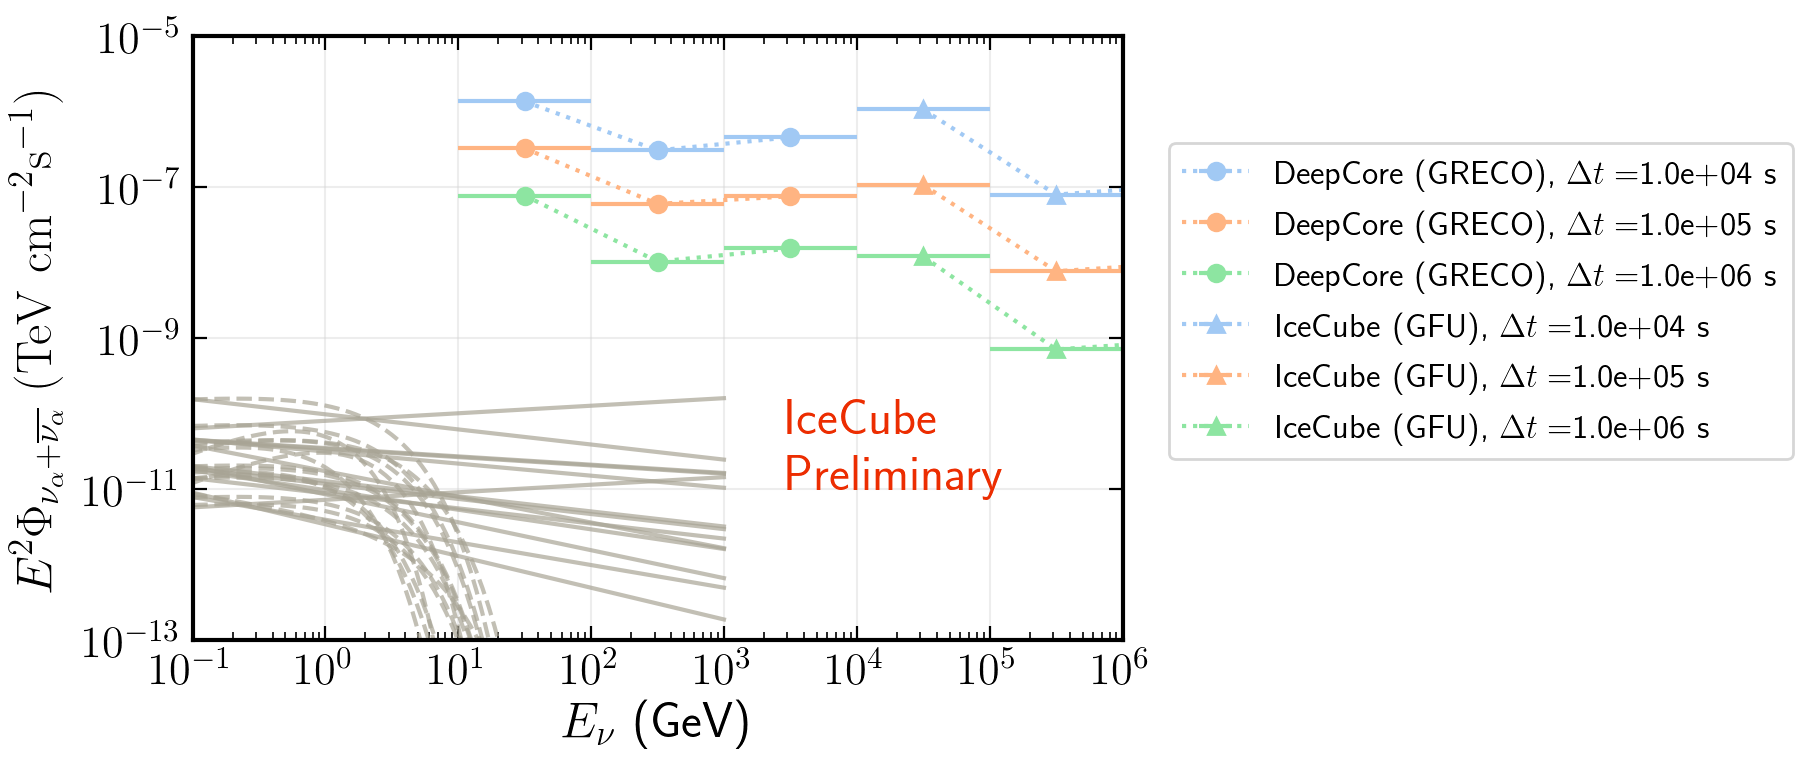

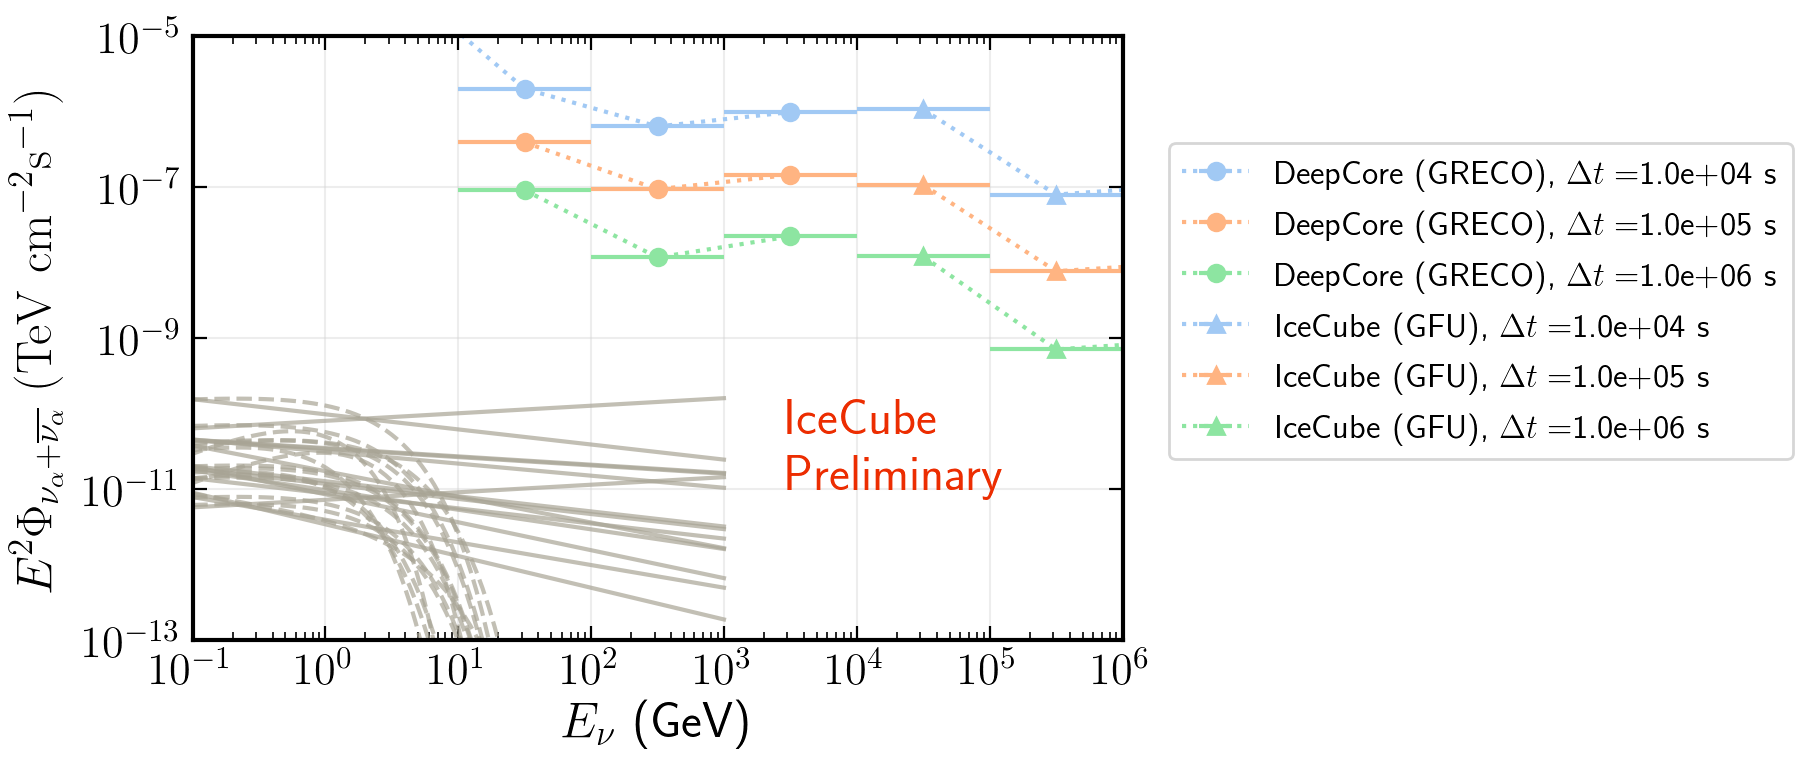

In [6]:
for all_flavor in [True, False]:
    fig = plt.figure(dpi=200)
    fig.set_facecolor('w')
    bin_width = np.sqrt(10.)

    for ii, delta_t in enumerate(np.logspace(4., 6., 3)):
        try:
            diff_e = differential_sensitivity(2, delta_t = delta_t, all_flavor=all_flavor) #ind 9 is ASASSN-16ma
            plt.errorbar(diff_e[0], diff_e[1]*1e-3,  #From GeV to TeV
                xerr=[diff_e[0]-diff_e[0]/bin_width, diff_e[0]*bin_width-diff_e[0]],
                marker='o', ls=':', label=r'DeepCore (GRECO), $\Delta t = $' + '{:.1e} s'.format(delta_t),
                color = palette[ii])
        except:
            continue


    for ii, delta_t in enumerate(np.logspace(4., 6., 3)):
        ndays = delta_t / 86400.
        gfu = np.load('/data/user/apizzuto/fast_response_skylab/dump/differential_sensitivity_deltaT_{:.2e}_sinDec_-0.50.pkl'.format(ndays),
                   allow_pickle=True)
        ens = np.array(gfu['low_energies'])*np.sqrt(10.)
        sens = np.array(gfu['sensitivity']) * 1e3 #1e6 for E_0^2, 1e-3 for GeV to TeV
        plt.errorbar(ens, sens,  #From GeV to TeV
            xerr=[ens-ens/bin_width, ens*bin_width-ens],
            marker='^', ls=':', label=r'IceCube (GFU), $\Delta t = $' + '{:.1e} s'.format(delta_t),
                    color=palette[ii])

    ens = np.logspace(-1.5, 3.0, 100)
    df = pd.read_csv('/home/apizzuto/Nova/Novae_details.csv')
    df = df.sort_values('Start Time (gamma ray)')
    for index, row in df.iterrows():
        nova = Nova(row['Name'], row['EPL gamma'], np.radians(row['RA (Deg)']), np.radians(row['Dec. (Deg)']), 
                    row['Start Time (gamma ray)'], row['Duration (gamma ray)'], flux_norm=row['EPL flux']*1e-7, cutoff = row['EPL cutoff '])
        nu_spec = nova.neutrino_spectrum(ens)
        plt.plot(ens, ens**2*nu_spec*1e-3, color = sns.xkcd_rgb['greyish'], 
                 lw = 1.5, alpha = 0.7, ls = '--')
        nova = Nova(row['Name'], row['SPL gamma'], np.radians(row['RA (Deg)']), np.radians(row['Dec. (Deg)']), 
                    row['Start Time (gamma ray)'], row['Duration (gamma ray)'], flux_norm=row['SPL flux']*1e-7, cutoff = None)
        nu_spec = nova.neutrino_spectrum(ens)
        plt.plot(ens, ens**2*nu_spec*1e-3, color = sns.xkcd_rgb['greyish'], 
                 lw = 1.5, alpha = 0.7)

    plt.loglog()
    plt.ylim(1e-13, 1e-5)
    plt.xlim(1e-1, 1e6)
    plt.legend(loc=(1.05, 0.3), fontsize=12, ncol=1)
    plt.xlabel(r'$E_{\nu}$ (GeV)')
    plt.ylabel(r'$E^2 \Phi_{\nu_{\alpha} + \overline{\nu_{\alpha}}}$ $(\rm TeV \,\, cm^{-2} s^{-1})$')
    plt.text(3e3, 1e-11, 'IceCube \n Preliminary', 
             color=sns.xkcd_rgb['tomato red'], fontsize=18)
    plt.savefig('/home/apizzuto/public_html/novae/differential_sensitivity_all_flavor_{}_preliminary_with_gamma_model.png'.format(all_flavor), 
                dpi=150, bbox_inches='tight')
    plt.show()

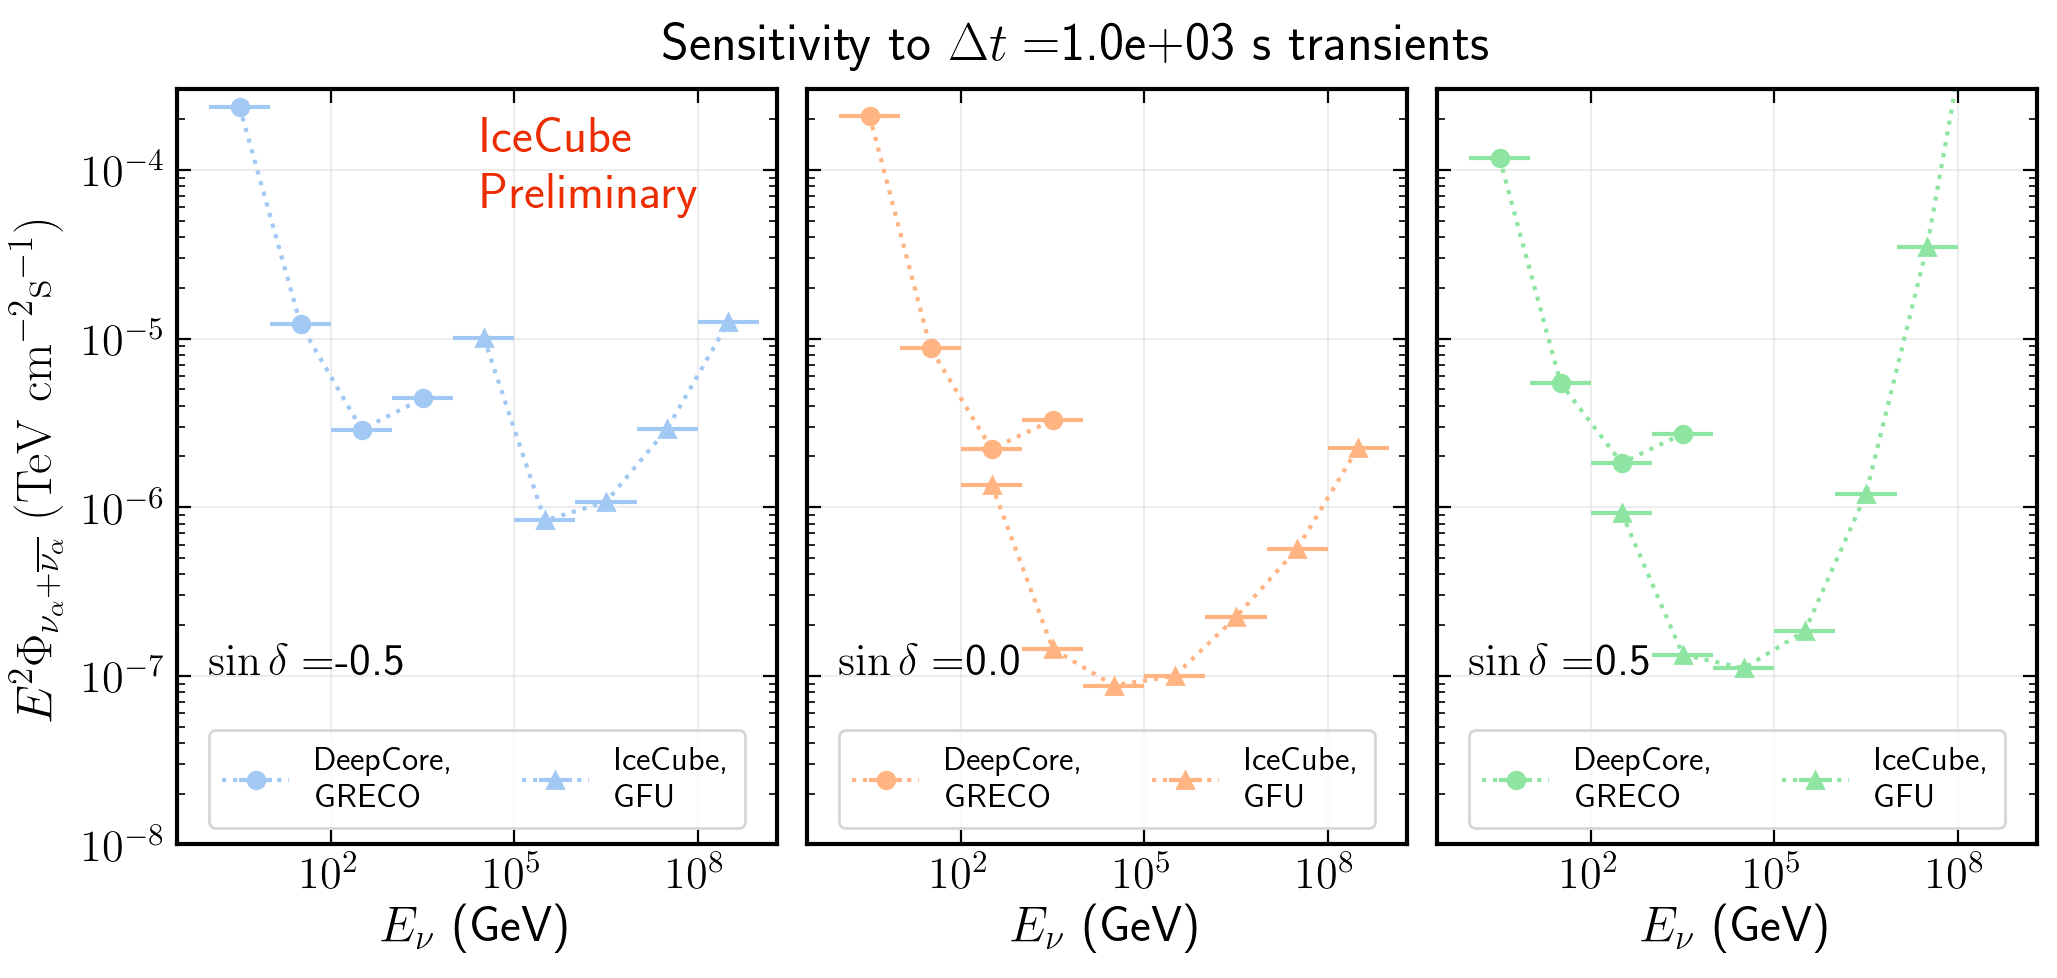

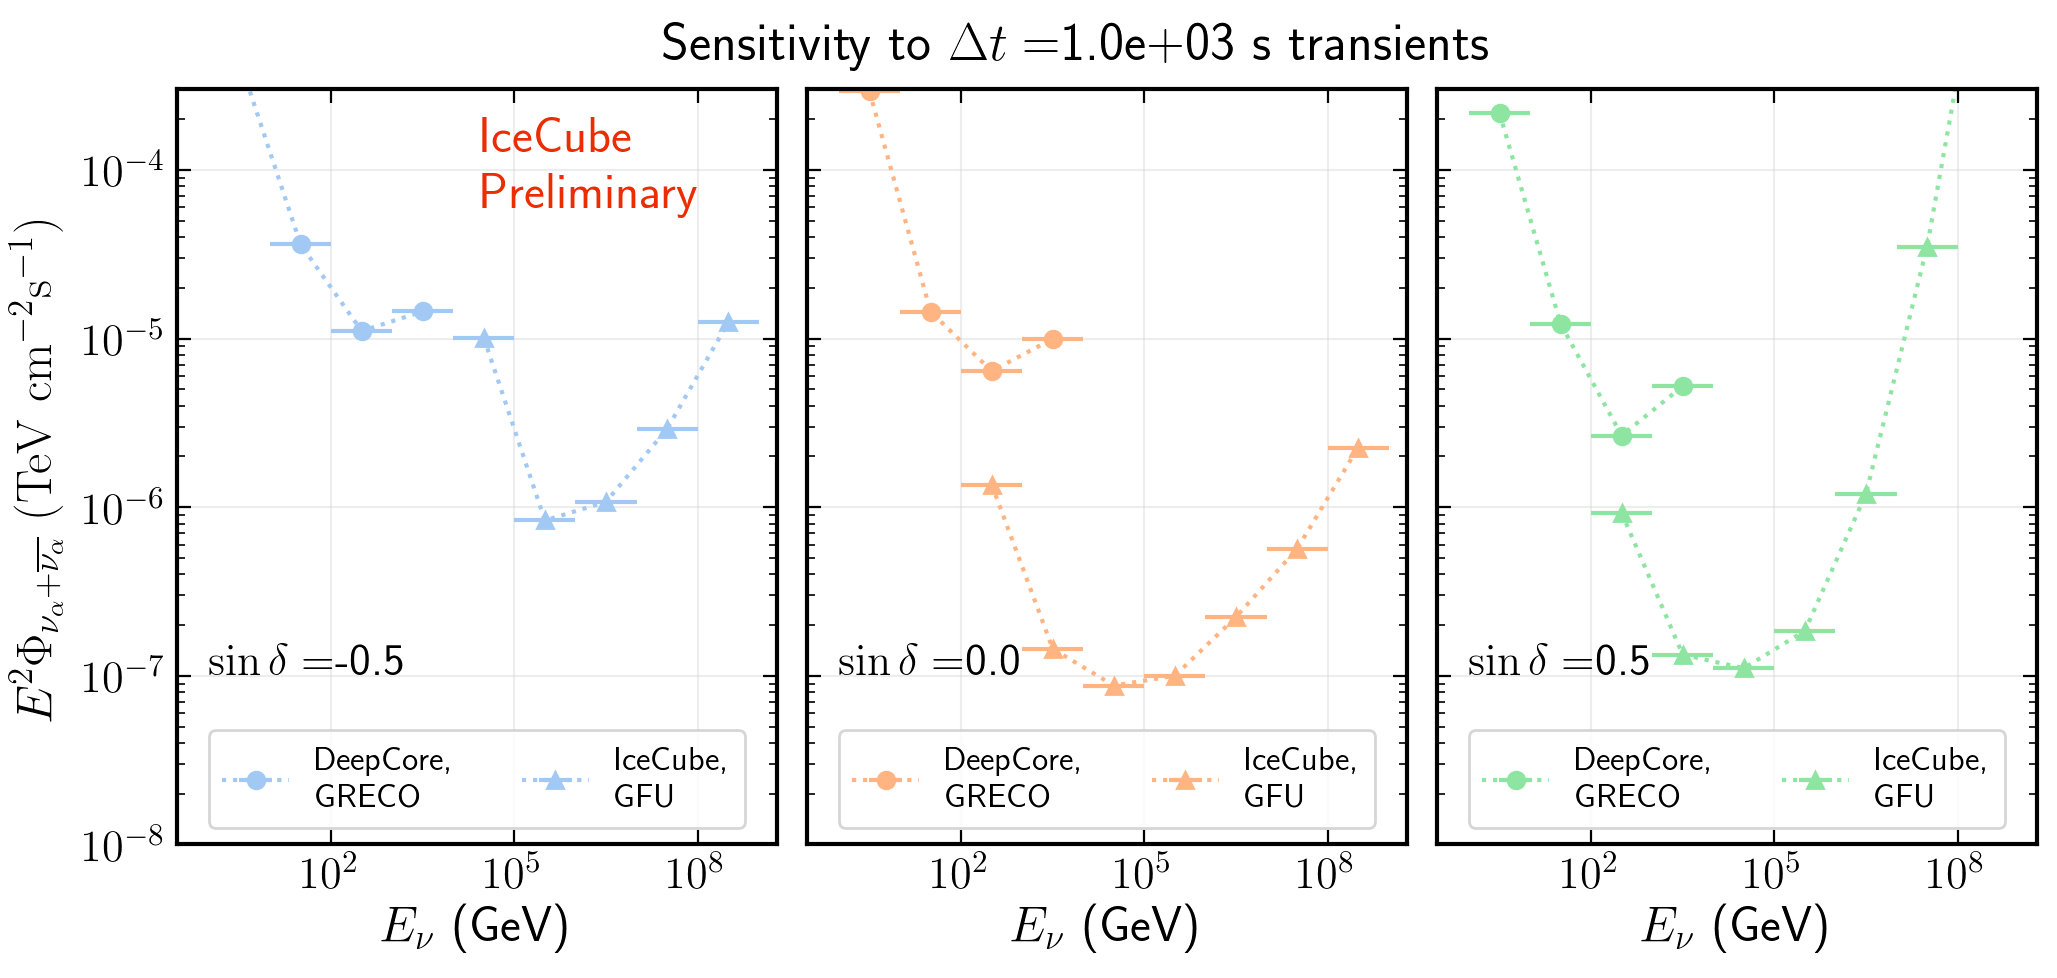

In [16]:
for all_flavor in [True, False]:
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,5), dpi=200, sharey=True)
    plt.subplots_adjust(wspace=0.05)
    fig.set_facecolor('w')
    bin_width = np.sqrt(10.)

    delta_t = 1e3
    for ii, (ind, dec) in enumerate(zip([1, 2, 5], [-30., 0., 30.])):
        diff_e = differential_sensitivity(ind, delta_t = delta_t, all_flavor=all_flavor)
        axs[ii].errorbar(diff_e[0], diff_e[1]*1e-3,  #From GeV to TeV
            xerr=[diff_e[0]-diff_e[0]/bin_width, diff_e[0]*bin_width-diff_e[0]],
            marker='o', ls=':', label='DeepCore,\n GRECO',
                    color = palette[ii])

        ndays = delta_t / 86400.
        gfu = np.load('/data/user/apizzuto/fast_response_skylab/dump/differential_sensitivity_deltaT_{:.2e}_sinDec_{:.2f}.pkl'.format(ndays, np.sin(np.radians(dec))),
                   allow_pickle=True)
        ens = np.array(gfu['low_energies'])*np.sqrt(10.)
        sens = np.array(gfu['sensitivity']) * 1e3 #1e6 for E_0^2, 1e-3 for GeV to TeV
        axs[ii].errorbar(ens, sens,  #From GeV to TeV
            xerr=[ens-ens/bin_width, ens*bin_width-ens],
            marker='^', ls=':', label='IceCube,\n GFU',
                    color=palette[ii])
        axs[ii].set_xscale('log')
        axs[ii].set_yscale('log')
        axs[ii].set_ylim(1e-8, 3e-4)
        axs[ii].set_xlim(3e-1, 2e9)
        axs[ii].legend(loc=8, fontsize=12, ncol=2)
        axs[ii].set_xlabel(r'$E_{\nu}$ (GeV)')
        axs[ii].text(1e0, 1e-7, r'$\sin \delta = $' +'{:.1f}'.format(np.sin(np.radians(dec))))
        if ii == 0:
            axs[ii].set_ylabel(r'$E^2 \Phi_{\nu_{\alpha} + \overline{\nu_{\alpha}}}$ $(\rm TeV \,\, cm^{-2} s^{-1})$')
    axs[0].text(3e4, 6e-5, 'IceCube \n Preliminary', 
             color=sns.xkcd_rgb['tomato red'], fontsize=18)
    plt.savefig('/home/apizzuto/public_html/novae/differential_sensitivity_all_flavor_{}_preliminary_panel.png'.format(all_flavor), 
                dpi=150, bbox_inches='tight')
    fig.suptitle(r'Sensitivity to $\Delta t =$' + '{:.1e} s transients'.format(delta_t), y=0.95)
    plt.show()